In [ ]:
# From OpenAI's github
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

class CartPoleEnv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
        Episode length is greater than 200
        Solved Requirements
        Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5 # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        state = self.state
        x, x_dot, theta, theta_dot = state
        force = self.force_mag if action==1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta* temp) / (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc  = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        if self.kinematics_integrator == 'euler':
            x  = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else: # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x  = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot
        self.state = (x,x_dot,theta,theta_dot)
        done =  x < -self.x_threshold \
                or x > self.x_threshold \
                or theta < -self.theta_threshold_radians \
                or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self, state=None):
        if state is None:
            self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
            self.steps_beyond_done = None
        else:
            self.state= np.array(state)
            self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold*2
        scale = screen_width/world_width
        carty = 100 # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l,r,t,b = -cartwidth/2, cartwidth/2, cartheight/2, -cartheight/2
            axleoffset =cartheight/4.0
            cart = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
            pole = rendering.FilledPolygon([(l,b), (l,t), (r,t), (r,b)])
            pole.set_color(.8,.6,.4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5,.5,.8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0,carty), (screen_width,carty))
            self.track.set_color(0,0,0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None: return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l,r,t,b = -polewidth/2,polewidth/2,polelen-polewidth/2,-polewidth/2
        pole.v = [(l,b), (l,t), (r,t), (r,b)]

        x = self.state
        cartx = x[0]*scale+screen_width/2.0 # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [ ]:
import math, gym, copy
import operator
import random
import pickle
import time 


cartpole = CartPoleEnv()

def approximate(raw_state):
    array = list(raw_state)
    return tuple([round(num, 2) + 0 for num in array])

def generate(lower_bound, upper_bound, interval):
    output = [lower_bound]
    while lower_bound <= upper_bound:
        lower_bound += interval
        output.append( float( round(lower_bound,1) + 0 ) )
    return output

def generate_states(x_approx, x_dot_approx, theta_approx, theta_dot_approx):
    states = []
    for x in x_approx:
        for x_dot in x_dot_approx:
            for theta in theta_approx:
                for theta_dot in theta_dot_approx:
                    states.append((x, x_dot, theta, theta_dot))
    return states

def get_value(state, value_function):
    try:
        next_state_value = value_function[state]
    except KeyError: # if next_state is not in value_function, assume it's a 'dead' state.
        next_state_value = -500
    return next_state_value

def create_transition_reward_function(states, actions, env):
    table = {}
    for state in states:
        for action in actions:
            env.reset(state)
            obs, reward, done, info = env.step(action)
            table[(state, action)] = {'reward':reward, 'next_state':approximate(obs)}
    return table

def evaluate_policy(state, actions, transition_and_reward_function, policy, value_function, gamma=1.0):
    new_val = 0
    for action in actions:
        reward, next_state = transition_and_reward_function[(state, action)].values()
        next_state_value = get_value(next_state, value_function)
        new_val += policy[state][action] * (reward + gamma*next_state_value)
    return new_val

def improve_policy(states, actions, transition_and_reward_function, value_function, gamma=1.0):
    new_policy = {}
    for state in states:
        action_values = {}
        for action in actions:
            reward, next_state = transition_and_reward_function[(state, action)].values()
            action_values[action] = reward + gamma*get_value(next_state, value_function)
        greedy_action, value = max(action_values.items(), key= lambda pair: pair[1])
        new_policy[state] = {action:1 if action is greedy_action else 0 for action in actions}
    return new_policy


# Policy iteration
def policy_iteration(states, actions, transition_and_reward_function, policy, value_function, number_of_iterations = 50):
    new_value_function = {}
    success_rate = []
    times = []
    for _ in range(number_of_iterations):
        print("iteration_number:",_)
        start = time.time()
        # Evaluate every state under current policy
        for state in states:
            new_value_function[state] = evaluate_policy(state, actions, transition_and_reward_function, policy, value_function)
        # Policy improvement
        policy = improve_policy(states, actions, transition_and_reward_function, new_value_function)
        value_function = new_value_function

        success_rate.append(testPolicy(policy))
        end = time.time()
        times.append(end-start)
    return policy, success_rate, times

def get_optimal_action(state, optimal_policy):
    try:
        greedy_action, prob = max(optimal_policy[state].items(), key= lambda pair: pair[1])
        return greedy_action
    except KeyError:
        return random.randint(0,1)

def testPolicy(optimal_policy, trials=100):
  # Running test episodes with optimal_policy
  total_steps = 0
  
  for episode in range(0,trials):
      observation = cartpole.reset()
      for timestep in range(1,101):
          #cartpole.render()
          action = get_optimal_action(approximate(observation), optimal_policy)
          observation, reward, done, info = cartpole.step(action)
          #print("Observation:", observation, ' ', "Action:", action)
          if done:
              #print("Episode {} finished after {} timesteps".format(episode,timestep))
              #print(observation)
              total_steps += timestep
              break
  uprightTime = total_steps/trials
  return uprightTime



if __name__ == '__main__':
    # Setting up
    x_approx = generate(-0.5, 0.5, 0.05)
    x_dot_approx = generate(-2.0, 2.0, 0.1)
    theta_approx = generate(-0.1, 0.1, 0.1) # theta_thres is 24deg, i.e. 24*2*pi/360 radians
    theta_dot_approx = generate(-3.0, 3.0, 0.1)
    states = generate_states(x_approx, x_dot_approx, theta_approx, theta_dot_approx)
    actions = [0,1]
    transition_and_reward_function = create_transition_reward_function(states, actions, cartpole)
    starting_policy = {state:{0:0.5, 1:0.5} for state in states}
    value_function = {state:0 for state in states}
    optimal_policy, success_rate, times = policy_iteration(states, actions, transition_and_reward_function, starting_policy, value_function)

    # Saving the optimal_policy on a file
    optimal = open('optimal.pkl','wb')
    pickle.dump(optimal_policy, optimal)
    optimal.close()
    print("done finding optimal_policy")



iteration_number: 0
iteration_number: 1
iteration_number: 2
iteration_number: 3
iteration_number: 4
iteration_number: 5
iteration_number: 6
iteration_number: 7
iteration_number: 8
iteration_number: 9
iteration_number: 10
iteration_number: 11
iteration_number: 12
iteration_number: 13
iteration_number: 14
iteration_number: 15
iteration_number: 16
iteration_number: 17
iteration_number: 18
iteration_number: 19
iteration_number: 20
iteration_number: 21
iteration_number: 22
iteration_number: 23
iteration_number: 24
iteration_number: 25
iteration_number: 26
iteration_number: 27
iteration_number: 28
iteration_number: 29
iteration_number: 30
iteration_number: 31
iteration_number: 32
iteration_number: 33
iteration_number: 34
iteration_number: 35
iteration_number: 36
iteration_number: 37
iteration_number: 38
iteration_number: 39
iteration_number: 40
iteration_number: 41
iteration_number: 42
iteration_number: 43
iteration_number: 44
iteration_number: 45
iteration_number: 46
iteration_number: 47
it

In [ ]:
# Running test episodes with optimal_policy
total_steps = 0
num_episodes = 10
for episode in range(0,num_episodes):
    observation = cartpole.reset()
    for timestep in range(1,101):
        #cartpole.render()
        action = get_optimal_action(approximate(observation), optimal_policy)
        observation, reward, done, info = cartpole.step(action)
        print("Observation:", observation, ' ', "Action:", action)
        if done:
            print("Episode {} finished after {} timesteps".format(episode,timestep))
            print(observation)
            total_steps += timestep
            break

print("average time upright per episode:", total_steps/num_episodes)

Observation: [-0.04558881 -0.19864859  0.0454579   0.27825752]   Action: 0
Observation: [-0.04956178 -0.39438857  0.05102305  0.5849242 ]   Action: 0
Observation: [-0.05744955 -0.59018671  0.06272154  0.89323346]   Action: 0
Observation: [-0.06925329 -0.39596896  0.0805862   0.62090774]   Action: 1
Observation: [-0.07717267 -0.59211835  0.09300436  0.93784369]   Action: 0
Observation: [-0.08901503 -0.78836291  0.11176123  1.25824221]   Action: 0
Observation: [-0.10478229 -0.59483434  0.13692608  1.00254987]   Action: 1
Observation: [-0.11667898 -0.401781    0.15697707  0.75581084]   Action: 1
Observation: [-0.1247146  -0.20913091  0.17209329  0.5163508 ]   Action: 1
Observation: [-0.12889722 -0.40620508  0.18242031  0.85794147]   Action: 0
Observation: [-0.13702132 -0.21397427  0.19957914  0.62771426]   Action: 1
Observation: [-0.1413008  -0.02211476  0.21213342  0.40392509]   Action: 1
Episode 0 finished after 12 timesteps
[-0.1413008  -0.02211476  0.21213342  0.40392509]
Observation:

Text(0, 0.5, 'Rewards')

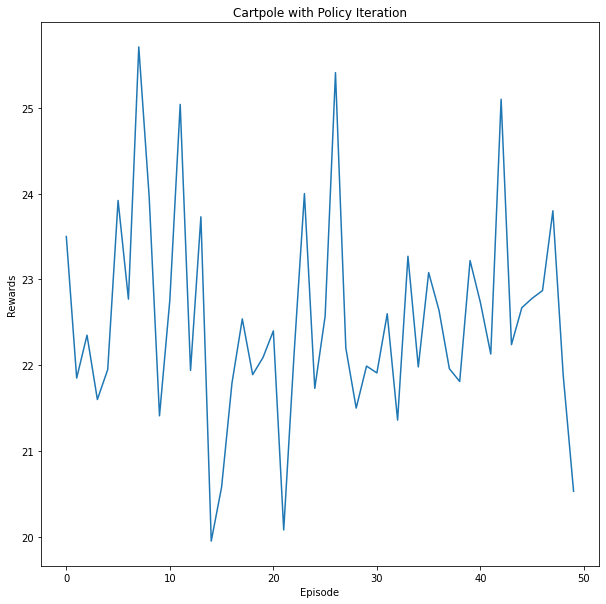

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(success_rate)
plt.title("Cartpole with Policy Iteration")
plt.xlabel("Episode")
plt.ylabel("Rewards")

Text(0, 0.5, 'Times')

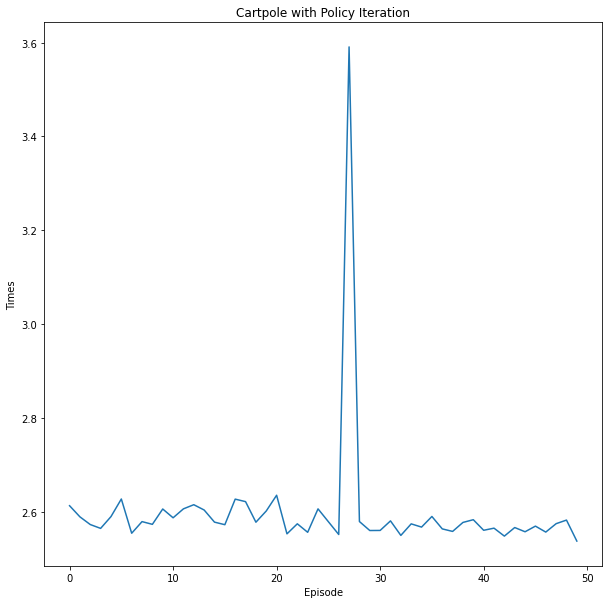

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(times)
plt.title("Cartpole with Policy Iteration")
plt.xlabel("Episode")
plt.ylabel("Times")